# PROMPT & IMAGE AUGMENTATION

This is a temporary notebook in which we will generate the prompt for clip given the set of classes from Flowers102.

In [ ]:
# Setup
# ! pip install -q -U google-genai
# ! pip install tqdm
# ! pip install openai_clip

import os
import torch
import json
import numpy as np
import torch.nn.functional as F

from tqdm import tqdm
from collections import defaultdict

**LIST of FLOWERS**
First we define the label name of all the 102 flower classes

In [ ]:
CLASS_NAMES = ["pink primrose", "hard-leaved pocket orchid", "canterbury bells", "sweet pea",
               "english marigold", "tiger lily", "moon orchid", "bird of paradise",
               "monkshood", "globe thistle", "snapdragon", "colt's foot", "king protea",
               "spear thistle", "yellow iris", "globe-flower", "purple coneflower",
               "peruvian lily", "balloon flower", "giant white arum lily", "fire lily",
               "pincushion flower", "fritillary", "red ginger", "grape hyacinth", "corn poppy",
               "prince of wales feathers", "stemless gentian", "artichoke", "sweet william",
               "carnation", "garden phlox", "love in the mist", "mexican aster",
               "alpine sea holly", "ruby-lipped cattleya", "cape flower", "great masterwort",
               "siam tulip", "lenten rose", "barbeton daisy", "daffodil", "sword lily",
               "poinsettia", "bolero deep blue", "wallflower", "marigold", "buttercup",
               "oxeye daisy", "common dandelion", "petunia", "wild pansy", "primula",
               "sunflower", "pelargonium", "bishop of llandaff", "gaura", "geranium",
               "orange dahlia", "pink-yellow dahlia?", "cautleya spicata", "japanese anemone",
               "black-eyed susan", "silverbush", "californian poppy", "osteospermum",
               "spring crocus", "bearded iris", "windflower", "tree poppy", "gazania",
               "azalea", "water lily", "rose", "thorn apple", "morning glory", "passion flower",
               "lotus", "toad lily", "anthurium", "frangipani", "clematis", "hibiscus",
               "columbine", "desert-rose", "tree mallow", "magnolia", "cyclamen", "watercress",
               "canna lily", "hippeastrum", "bee balm", "ball moss", "foxglove", "bougainvillea",
               "camellia", "mallow", "mexican petunia", "bromelia", "blanket flower",
               "trumpet creeper", "blackberry lily"]

CLASS_NAMES_12 = ["pink primrose", "hard-leaved pocket orchid", "canterbury bells", "sweet pea",
               "english marigold", "tiger lily", "moon orchid", "bird of paradise",
               "monkshood", "globe thistle", "snapdragon", "colt's foot"]

In [ ]:
import torch, torchvision
from torchvision.datasets import Flowers102

def get_test_data(data_dir="./data", transform=None):
    """Load Flowers102 train, validation and test sets.
    Args:
        data_dir (str): Directory where the dataset will be stored.
        transform (torch.Compose)
    Returns:
        tuple: A tuple containing the train, validation, and test sets.
    """
    # Load Oxford Flowers test split and class names
    test = torchvision.datasets.Flowers102(root=data_dir, split="test", download=True, transform=transform)
    return test

### Prompt Generation
Here we ask throught API to Google Gemini to derive N prompts for each class. We define a clear prompt for Gemini where we define the number of prompts for each class and define a structured form of the output to better menage it.

In [ ]:
NUM_OF_VARIANTS = 10

SYSTEM_PROMPT = f"""You are a vision-language expert.

Input format
• The user will give one Oxford-102 flower class name (e.g. “Daffodil”).

Output format
• Return **exactly {NUM_OF_VARIANTS}** short, visually grounded prompts.
• Separate the prompts with **“; ”** (semicolon + space).
• Do **not** add a semicolon after the final prompt.
• Output nothing else.

Content rules for each prompt
1. Start with a different prefix chosen from this set (use each at most once):
   “A photo of a”, “An image of a”, “A close-up of a”, “A macro shot of a”,
   “A studio photo of a”, “An outdoor photo of a”, “A botanical plate of a”,
   “A well-lit photograph of a”, “A side view of a”, “A top-down view of a”.
2. Immediately include the **number of flowers** in the frame (e.g. “single”, “one”, “pair of”, “three”).
3. Name the flower class exactly as given.
4. Mention dominant colour(s) plus 1-2 key visual cues (petal count/shape, centre, leaves, stem).
5. Keep each prompt ≤ 25 words.
6. Use only information visible in a typical image; avoid subjective or non-visual terms (beautiful, symbolic, fragrant, etc.).
7. End each prompt **without** a period.

Return the ten prompts in one line, separated by “; ”, and nothing else.
"""

In [ ]:
from google import genai
from google.genai import types

# GEMINI API KEY IN SECRET's SECTION (left menu)
'''
# If noteboock in Google Colab
from google.colab import userdata
userdata.get('GEMINI_API_KEY')
'''

# If noteboock in Jupiter
from dotenv import load_dotenv

load_dotenv()
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
# print(gemini_api_key)

client = genai.Client(api_key=GEMINI_API_KEY)

In [ ]:
def generate_classes_prompt_variants(classes: list):
    '''
    This function generate a set of N prompts for each class in the input list parameter
    '''
    prompt_variants_dict = {}

    # Iterate each class: i is the class number, c is the class label
    for i, c in enumerate(classes):
        try:
            # Send the request to gemini with API
            response = client.models.generate_content(
                model="gemini-2.5-flash",
                config=types.GenerateContentConfig(
                    system_instruction=SYSTEM_PROMPT,
                    temperature=0.1
                ),
                contents=c
            )
            # Extract the response
            all_prompts = response.text
            prompt_variants_dict[c] = all_prompts.split('; ')
            print(f"✅ Finished class {c} - {i+1}/{len(classes)}")

        except Exception as e:
            print(f"❌ Error generating class '{c}' - {i+1}/{len(classes)}: {e}")
            prompt_variants_dict[c] = []  # oppure `None`, a seconda di cosa preferisci

    return prompt_variants_dict

We initialize our system by define the prompts for each of the 102 classes of our database. Either this the code is orgnaized in order to flexible and easy to generate new prompts for new classes.

To avoid overload Gemnin and risk to get lower quality result we devide the classes in small batches of 6 classes each one.

In [ ]:
def init_prompts():

    # orgnize classes in chunck of 6 units
    chunk_size = 6
    chunked_class_names = [CLASS_NAMES[i:i + chunk_size] for i in range(0, len(CLASS_NAMES), chunk_size)]

    dict_list = []  # list containing the generated dictionaries
    for chunk in tqdm(chunked_class_names, desc="Generating dictionaries"):
        variants_dict = generate_classes_prompt_variants(chunk)   # generate the prompts for the chunk's classes
        dict_list.append(variants_dict)

    # Unify all the dictionries of the cunks in only one dictionary
    unified_dict = defaultdict(list)
    for diz in dict_list:
        for key, val in diz.items():
            unified_dict[key].extend(val)

    prompt_of_variants = dict(unified_dict)

    with open('generated_prompts.json', 'w') as f:
        json.dump(prompt_of_variants, f, indent=4)

You can both generate all the labels with init_prompts() or download the json generated by us from github

In [ ]:
# init_prompts()
!git clone --recurse-submodules https://github.com/matteogrisenti/CLIP-zero-shot/tree/master/generated_prompts.json

Generating dictionaries:   0%|          | 0/2 [00:00<?, ?it/s]

✅ Finished class pink primrose - 1/6
✅ Finished class hard-leaved pocket orchid - 2/6
✅ Finished class canterbury bells - 3/6
✅ Finished class sweet pea - 4/6
✅ Finished class english marigold - 5/6


Generating dictionaries:  50%|█████     | 1/2 [00:37<00:37, 37.94s/it]

✅ Finished class tiger lily - 6/6
✅ Finished class moon orchid - 1/6
✅ Finished class bird of paradise - 2/6
✅ Finished class monkshood - 3/6
✅ Finished class globe thistle - 4/6
✅ Finished class snapdragon - 5/6


Generating dictionaries: 100%|██████████| 2/2 [01:18<00:00, 39.31s/it]

✅ Finished class colt's foot - 6/6


In [ ]:
def load_prompts(json_path='generated_prompts.json'):
    """
    Reads the generated prompts from a JSON file and returns them as a dictionary.

    Args:
        json_path (str): Path to the JSON file containing the prompts.

    Returns:
        dict: Dictionary with class names as keys and list of prompt variants as values.
    """
    with open(json_path, 'r') as f:
        prompt_dict = json.load(f)
    return prompt_dict

Example of flowers images and the generated prompts

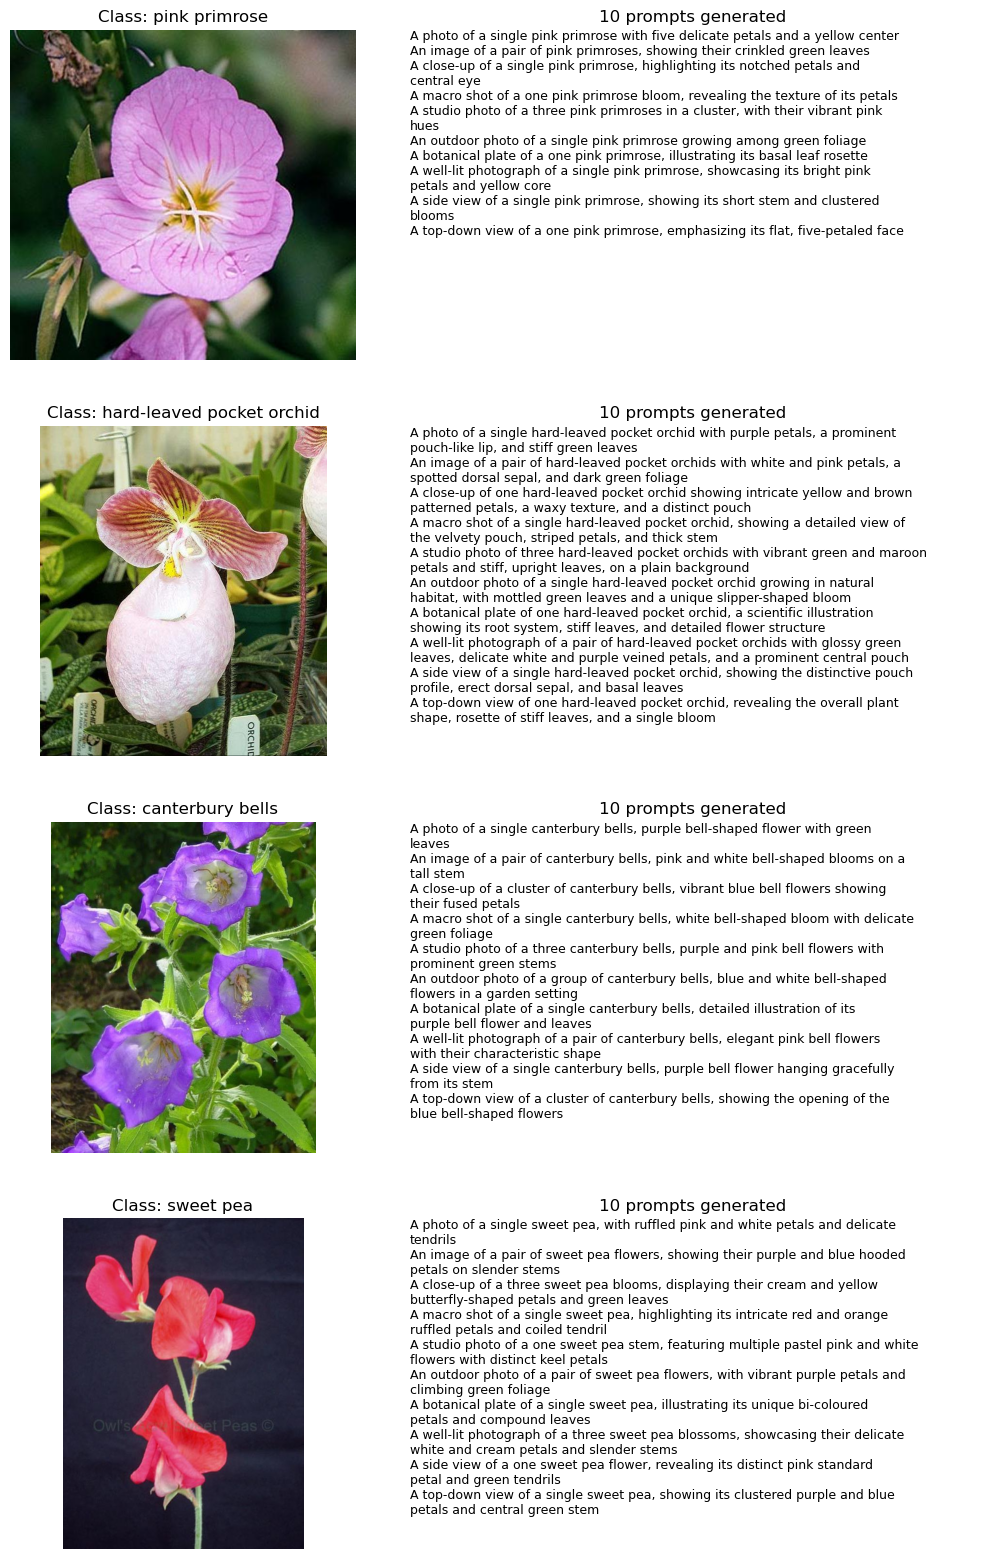

In [ ]:
import torch, torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torchvision.datasets import Flowers102

import textwrap

test_images = get_test_data()

generated_prompts = load_prompts()

# Trova un'immagine per ciascuna delle prime 4 classi
selected_images = []
selected_labels = []

target_classes = list(range(4))  # classi 0, 1, 2, 3
found_classes = set()

for img, label in test_images:
    if label in target_classes and label not in found_classes:
        selected_images.append(img)
        selected_labels.append(label)
        found_classes.add(label)
    if len(found_classes) == 4:
        break

# Visualizza
fig, axs = plt.subplots(4, 2, figsize=(12, 16))

for i in range(4):
    image = selected_images[i]
    label = selected_labels[i]

    class_name = CLASS_NAMES[label]
    prompts = generated_prompts.get(class_name, ["(no prompts found)"] * 10)

    wrapped_prompts = []
    max_width = 80  # numero massimo di caratteri per riga

    for p in prompts[:10]:
        wrapped = textwrap.fill(p, width=max_width)
        wrapped_prompts.append(wrapped)

    text_to_show = "\n".join(wrapped_prompts)  # doppio newline per separare i prompt

    # Colonna sinistra: immagine
    axs[i, 0].imshow(image)
    axs[i, 0].axis('off')
    axs[i, 0].set_title(f"Class: {class_name}", fontsize=12)

    # Colonna destra: prompt
    axs[i, 1].text(0, 1, text_to_show, va='top', fontsize=9)
    axs[i, 1].axis('off')
    axs[i, 1].set_title("10 prompts generated", fontsize=12)

plt.tight_layout()
plt.show()

## IMAGE AUGMENTATIO

In [ ]:
!pip install "numpy==1.26.4"
!pip uninstall -y opencv-python opencv-python-headless
!pip install "opencv-python-headless<4.12"

# !git clone --recurse-submodules https://github.com/FilippoAdami/Zero123-Acc
%cd zero123plus

# Install required packages
!pip install -r requirements.txt
!pip install diffusers torch transformers  # ensure essential diffusers+torch
!pip install einops
!pip install pytorch-lightning

Found existing installation: opencv-python-headless 4.11.0.86
Uninstalling opencv-python-headless-4.11.0.86:
  Successfully uninstalled opencv-python-headless-4.11.0.86
  Using cached opencv_python_headless-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached opencv_python_headless-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (50.0 MB)
/mnt/custom-file-systems/efs/fs-0413cdbb1ba5d0975_fsap-0a6855ae0e1d0db2c/zero123plus
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-fv07xz_1
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-fv07xz_1
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Using cached rembg-2.0.67-py3-none-any.whl.metadata (21 kB)
  Using cached opencv_contrib_python-4.12.0.88-cp37

In [ ]:

!pip install pytorch-lightning==1.9.0
import path_setup

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.8/825.8 kB 47.0 MB/s eta 0:00:00
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 2.5.1.post0
    Uninstalling pytorch-lightning-2.5.1.post0:
      Successfully uninstalled pytorch-lightning-2.5.1.post0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-timeseries 1.2 requires coreforecast==0.0.12, but you have coreforecast 0.0.16 which is incompatible.
autogluon-timeseries 1.2 requires mlforecast==0.13.4, but you have mlforecast 0.13.6 which is incompatible.
autogluon-timeseries 1.2 requires transformers[sentencepiece]<4.50,>=4.38.0, but you have transformers 4.52.1 which is incompatible.
✅ Path setup completato.
⚙️ Initializing models on cuda:0...


ImportError: cannot import name '_distributed_available' from 'lightning_fabric.utilities.distributed' (/opt/conda/lib/python3.12/site-packages/lightning_fabric/utilities/distributed.py)

In [ ]:
from app import generate_novel_views
from PIL import Image

# Pick one test image from the dataset
index = 104  # Change this for different test examples
test_img, test_label = flowers[index]
input_image_path_1 = '/content/input.jpg'
test_img.save(input_image_path_1)

# Generate Zero123 views
print(f"\n--- Generating Views for '{class_names[test_label]}' ---")
images = generate_novel_views(img_path=input_image_path_1)
print(f"✅ View generation complete.")

ModuleNotFoundError: No module named 'einops'

# TESTING
1) Vanilla CLIP Zero Shot Classification
2) Only Prmpts Solution
3) Only Images Solution

In [ ]:
def split_data(dataset):
    # these two lists will store the sample indexes
    base_categories_samples = []
    novel_categories_samples = []

    # we know that the first 50 classes belong to the Base group, whilt the others to Novel
    base_set = set(range(0, 51))

    # here we iterate over sample labels and also get the correspondent sample index
    for sample_id, label in enumerate(dataset._labels):
        if label in base_set:
            base_categories_samples.append(sample_id)
        else:
            novel_categories_samples.append(sample_id)

    # here we create the dataset subsets; the torch Subset is just a wrapper around the dataset
    # it simply stores the subset indexes and the original dataset (your_subset.dataset)
    # when asking for sample i in the subset, torch will look for its original position in the dataset and retrieve it
    base_dataset = torch.utils.data.Subset(dataset, base_categories_samples)
    novel_dataset = torch.utils.data.Subset(dataset, novel_categories_samples)

    return base_dataset, novel_dataset

## VANILLA CLIP ZERO SHOT CLASSIFICATION

In [ ]:
@torch.no_grad() # we don't want gradients
def eval_vanilla_clip(model, dataset, categories, batch_size, device, label=""):
    # let's set the model in evaluation mode
    model.eval()

    # Remap labels into a contiguous set starting from zero
    contig_cat2idx = {cat: idx for idx, cat in enumerate(categories)}

    # here we apply the standard CLIP template used for oxford flowers to all categories
    # and immediately tokenize each sentence (convert natural language into numbers - feel free to print the text input to inspect them)
    text_inputs = clip.tokenize(
        [f"a photo of a {CLASS_NAMES[c]}, a type of flower." for c in categories]
    ).to(device)

    # we can encode the text features once as they are shared for all images
    # therefore we do it outside the evaluation loop
    text_features = model.encode_text(text_inputs)
    # and here we normalize them (standard pratice with CLIP)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    # simple dataloader creation
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    # here we store the number of correct predictions we will make
    correct_predictions = 0
    for image, target in tqdm(dataloader, desc=label):
        # base categories range from 0 to 50, whil novel ones from 51 to 101
        # therefore we must map categories to the [0, 50], otherwise we will have wrong predictions
        # Map targets in contiguous set starting from zero
        # Labels needs to be .long() in pytorch
        target = torch.Tensor([contig_cat2idx[t.item()] for t in target]).long()

        image = image.to(device)
        target = target.to(device)

        # forward image through CLIP image encoder
        image_features = model.encode_image(image)
        # and normalize
        image_features /= image_features.norm(dim=-1, keepdim=True)

        # here cosine similarity between image and text features and keep the argmax for every row (every image)
        predicted_class = (image_features @ text_features.T).argmax(dim=-1)
        # now we check which are correct, and sum them (False == 0, True == 1)
        correct_predictions += (predicted_class == target).sum().item()

    # and now we compute the accuracy
    accuracy = correct_predictions / len(dataset)
    return accuracy

In [ ]:
import clip
import torch
from torchvision.datasets import Flowers102
from torchvision import transforms

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess_clip = clip.load("ViT-B/16", device=device)

test_dataset = get_test_data(transform=preprocess_clip)
base_test_dataset, novel_test_dataset = split_data(test_dataset)

base_classes = list(range(51))           # [0, 1, ..., 50]
novel_classes = list(range(51, 102))     # [51, 52, ..., 101]

base_accuracy = eval_vanilla_clip(model=model, dataset=base_test_dataset, categories=base_classes, batch_size=128, device=device, label="🧠 Zero-shot evaluation on Base Classes")
novel_accuracy = eval_vanilla_clip(model=model, dataset=novel_test_dataset, categories=novel_classes, batch_size=128, device=device, label="🧠 Zero-shot evaluation on Novel Classes")

print()
print(f"🔍 Base classes accuracy: {base_accuracy*100:.2f}%")
print(f"🔍 Novel classes accuracy: {novel_accuracy*100:.2f}%")

🧠 Zero-shot evaluation on Novel Classes: 100%|██████████| 29/29 [00:18<00:00,  1.58it/s]


🔍 Base classes accuracy: 71.33%
🔍 Novel classes accuracy: 78.24%


## ONLY PRMPTS AGUMENTATION

In [ ]:
import torch

@torch.no_grad() # we don't want gradients
def eval_only_prompts(model, dataset, prompt_dict, batch_size, device, label=""):

    model.eval()        # let's set the model in evaluation mode

    # get features (average embedding for each class)
    class_features = []

    # Ordine fisso → ci servirà per mappare i target
    ordered_keys = list(prompt_dict.keys())

    for k in ordered_keys:
        prompts = prompt_dict[k]                     # lista di stringhe

        embeddings = []
        for prompt in prompts:
            tokens = clip.tokenize(prompt, truncate=True).to(device)  # [N_prompts, 77]

            # Encode & normalize i prompt
            emb = model.encode_text(tokens)        # [N_prompts, 512]
            emb = emb / emb.norm(dim=-1, keepdim=True)
            embeddings.append(emb.squeeze(0))  # [512]

        # Media + rinormalizzazione
        cls_emb = torch.stack(embeddings).mean(dim=0)                   # [512]
        cls_emb = cls_emb / cls_emb.norm()

        class_features.append(cls_emb)

    # Stack → [num_classi, 512]
    text_features = torch.stack(class_features)


    # Remap labels into a contiguous set starting from zero
    contig_cat2idx = {idx: idx for idx, cat in enumerate(ordered_keys)}


    # simple dataloader creation
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    # here we store the number of correct predictions we will make
    correct_predictions = 0
    for image, target in tqdm(dataloader, desc=label):
        # base categories range from 0 to 50, whil novel ones from 51 to 101
        # therefore we must map categories to the [0, 50], otherwise we will have wrong predictions
        # Map targets in contiguous set starting from zero
        # Labels needs to be .long() in pytorch
        target = torch.Tensor([contig_cat2idx[t.item()] for t in target]).long()

        image = image.to(device)
        target = target.to(device)

        # forward image through CLIP image encoder
        image_features = model.encode_image(image)
        # and normalize
        image_features /= image_features.norm(dim=-1, keepdim=True)

        # here cosine similarity between image and text features and keep the argmax for every row (every image)
        predicted_class = (image_features @ text_features.T).argmax(dim=-1)
        # now we check which are correct, and sum them (False == 0, True == 1)
        correct_predictions += (predicted_class == target).sum().item()


    # and now we compute the accuracy
    accuracy = correct_predictions / len(dataset)
    return accuracy

In [ ]:
import clip
import torch
from torchvision.datasets import Flowers102
from torchvision import transforms

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess_clip = clip.load("ViT-B/16", device=device)

test_dataset = get_test_data(transform=preprocess_clip)
base_test_dataset, novel_test_dataset = split_data(test_dataset)

generated_prompts = load_prompts()

base_accuracy = eval_only_prompts(model=model, dataset=base_test_dataset, prompt_dict=generated_prompts, batch_size=128, device=device, label="🧠 Zero-shot evaluation on Base Classes")
novel_accuracy = eval_only_prompts(model=model, dataset=novel_test_dataset, prompt_dict=generated_prompts, batch_size=128, device=device, label="🧠 Zero-shot evaluation on Novel Classes")

print()
print(f"🔍 Base classes accuracy: {base_accuracy*100:.2f}%")
print(f"🔍 Novel classes accuracy: {novel_accuracy*100:.2f}%")

🧠 Zero-shot evaluation on Novel Classes: 100%|██████████| 29/29 [00:18<00:00,  1.56it/s]


🔍 Base classes accuracy: 66.96%
🔍 Novel classes accuracy: 70.08%


## ONLY IMAGE AUGMENTATION

In [ ]:
import tourch

@torch.no_grad() # we don't want gradients
def eval_only_images(model, dataset, categories, batch_size, device, label=""):
    # let's set the model in evaluation mode
    model.eval()

    # Remap labels into a contiguous set starting from zero
    contig_cat2idx = {cat: idx for idx, cat in enumerate(categories)}

    # here we apply the standard CLIP template used for oxford flowers to all categories
    # and immediately tokenize each sentence (convert natural language into numbers - feel free to print the text input to inspect them)
    text_inputs = clip.tokenize(
        [f"a photo of a {CLASS_NAMES[c]}, a type of flower." for c in categories]
    ).to(device)

    # we can encode the text features once as they are shared for all images
    # therefore we do it outside the evaluation loop
    text_features = model.encode_text(text_inputs)
    # and here we normalize them (standard pratice with CLIP)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    # simple dataloader creation
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    # here we store the number of correct predictions we will make
    correct_predictions = 0
    for image, target in tqdm(dataloader, desc=label):
        target = torch.Tensor([contig_cat2idx[t.item()] for t in target]).long()
        target = target.to(device)

        novel_views_images = generate_novel_views(image)
        novel_views_scores = []

        for novel_view_image in novel_views_images:
            novel_view_image = novel_view_image.to(device)


            # forward image through CLIP image encoder
            image_features = model.encode_image(image)
            # and normalize
            image_features /= image_features.norm(dim=-1, keepdim=True)

            # here cosine similarity between image and text features and keep the argmax for every row (every image)
            classes_scores = (image_features @ text_features.T)
            novel_views_scores.append(classes_scores)

        mean_classes_scores = novel_views_scores.mean()

        # now we check which are correct, and sum them (False == 0, True == 1)
        predicted_class = (image_features @ text_features.T).argmax(dim=-1)
        correct_predictions += (predicted_class == target).sum().item()

    # and now we compute the accuracy
    accuracy = correct_predictions / len(dataset)
    return accuracy